# Upload Data


## Imports and Auxiliary Function

<p>The following are the libraries we are going to use for this lab:</p>

In [5]:
import tensorflow as tf

AttributeError: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)

In [1]:
import os
import tensorflow as tf
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras import optimizers, regularizers

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, BatchNormalization,  GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard

import warnings
warnings.filterwarnings("ignore")

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
def plot_loss(history):
  plt.figure(figsize=(20, 10))
  sns.set_style('whitegrid')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Wildfire Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

In [5]:
def plot_acc(history):
  plt.figure(figsize=(20, 10))
  sns.set_style('whitegrid')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Wildfire Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
  plt.show()

In [6]:
def compute_class_freqs(labels):
    
  # total number of patients (rows)
  N = np.shape(labels)[0]
  
  positive_frequencies = np.sum(labels, axis = 0) / N
  negative_frequencies = 1 - positive_frequencies

  return positive_frequencies, negative_frequencies

# Dataset Preparation

In [7]:
train_path = "./data/train"
valid_path = "./data/valid"
test_path = "./data/test"

In [8]:
im_size = 224 #@param {type:"slider", min:64, max:350, step:1}
image_resize = (im_size, im_size, 3) 
batch_size_training = 100 #@param {type:"number"}
batch_size_validation = 100 #@param {type:"number"}
batch_size_test = 100 #@param {type:"number"}
num_classes = 2 #@param {type:"number"}

In [9]:
data_generator = ImageDataGenerator(dtype='float32', rescale= 1./255.)

In [10]:
train_generator = data_generator.flow_from_directory(train_path,
                                                   batch_size = batch_size_training,
                                                   target_size = (im_size, im_size),
                                                   class_mode = 'categorical')

valid_generator = data_generator.flow_from_directory(valid_path,
                                                   batch_size = batch_size_validation,
                                                   target_size = (im_size, im_size),
                                                   class_mode = 'categorical')

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [11]:
class_mapping = train_generator.class_indices
class_mapping

{'nowildfire': 0, 'wildfire': 1}

In [12]:
pip install Pillow


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
first_batch_train = train_generator.next()
first_batch_train

(array([[[[0.4156863 , 0.41960788, 0.34901962],
          [0.49411768, 0.49803925, 0.427451  ],
          [0.54901963, 0.5529412 , 0.48235297],
          ...,
          [0.63529414, 0.6431373 , 0.5882353 ],
          [0.6313726 , 0.6392157 , 0.58431375],
          [0.627451  , 0.6392157 , 0.57254905]],
 
         [[0.50980395, 0.52156866, 0.44705886],
          [0.53333336, 0.54509807, 0.47058827],
          [0.5529412 , 0.57254905, 0.49411768],
          ...,
          [0.7058824 , 0.7137255 , 0.6627451 ],
          [0.69803923, 0.7058824 , 0.6509804 ],
          [0.68235296, 0.6901961 , 0.63529414]],
 
         [[0.5058824 , 0.5254902 , 0.44705886],
          [0.49803925, 0.5176471 , 0.43921572],
          [0.5058824 , 0.5372549 , 0.454902  ],
          ...,
          [0.6509804 , 0.65882355, 0.6156863 ],
          [0.654902  , 0.6627451 , 0.6117647 ],
          [0.65882355, 0.6666667 , 0.6117647 ]],
 
         ...,
 
         [[0.44705886, 0.5058824 , 0.42352945],
          [0.43137

In [14]:
import PIL
print(PIL.__version__)
print(PIL.__file__)


10.4.0
g:\AProjects\FireCast\.venv\lib\site-packages\PIL\__init__.py


In [15]:
first_batch_valid = valid_generator.next()
first_batch_valid

(array([[[[0.16078432, 0.25490198, 0.15294118],
          [0.07058824, 0.16470589, 0.0627451 ],
          [0.10980393, 0.20392159, 0.10196079],
          ...,
          [0.13725491, 0.23529413, 0.12156864],
          [0.02352941, 0.12156864, 0.00784314],
          [0.1764706 , 0.27450982, 0.16078432]],
 
         [[0.05490196, 0.14509805, 0.04313726],
          [0.09803922, 0.18823531, 0.08627451],
          [0.16862746, 0.25882354, 0.15686275],
          ...,
          [0.19215688, 0.28235295, 0.17254902],
          [0.16078432, 0.2509804 , 0.14117648],
          [0.1764706 , 0.26666668, 0.15686275]],
 
         [[0.0627451 , 0.14117648, 0.04313726],
          [0.09411766, 0.17254902, 0.07450981],
          [0.08627451, 0.1764706 , 0.07450981],
          ...,
          [0.20784315, 0.29803923, 0.18823531],
          [0.16078432, 0.2509804 , 0.14117648],
          [0.24313727, 0.33333334, 0.22352943]],
 
         ...,
 
         [[0.2392157 , 0.3372549 , 0.21176472],
          [0.18431

In [16]:
labels = np.array(['nowildfire', 'wildfire'])

In [17]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

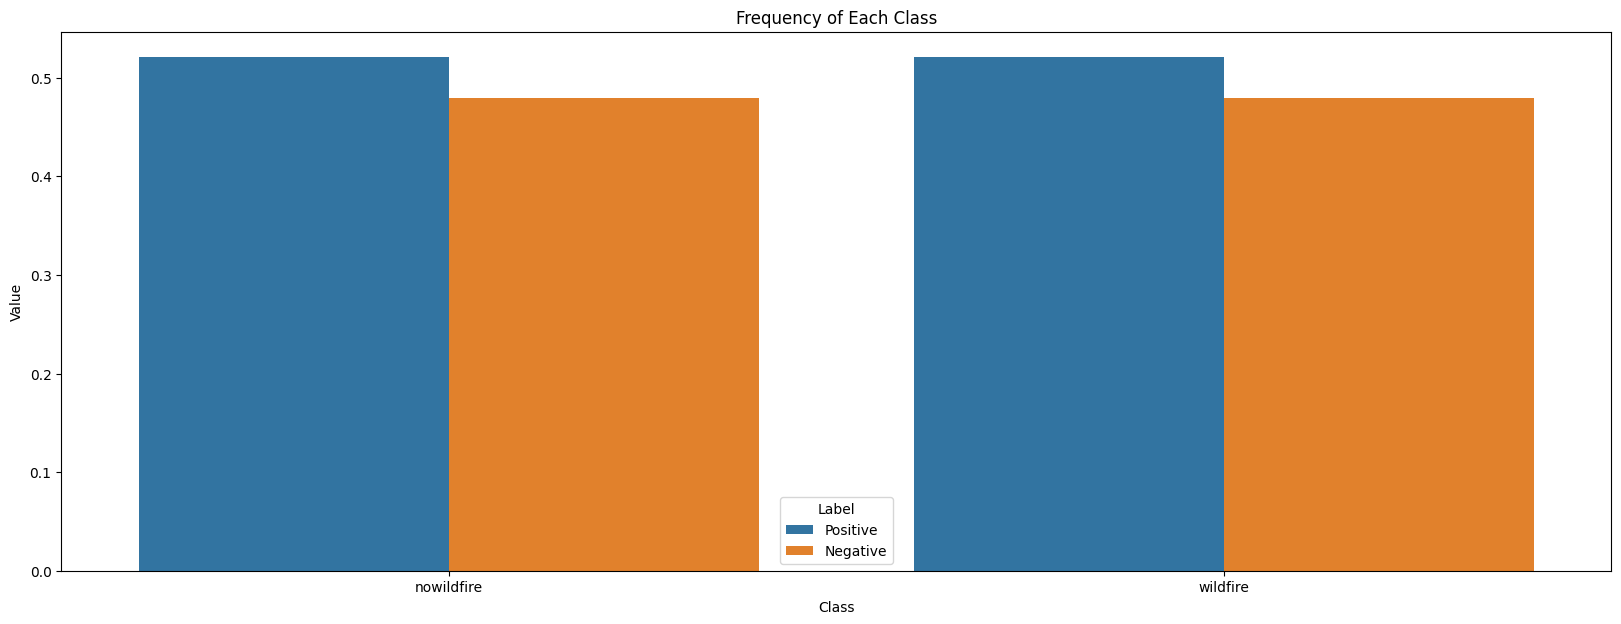

In [18]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})

neg_rows = []
for i in range(2):
    neg_rows.append({"Class": labels[i], "Label": "Negative", "Value": freq_neg})

neg_df = pd.DataFrame(neg_rows)

# Concatenate dataframes using pd.concat (function)
data = pd.concat([data, neg_df], ignore_index=True)

plt.figure(figsize=(20, 7))
plt.title("Frequency of Each Class")
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)


# Compile and Fit Custom Model

In [19]:
def base_model(input_shape, repetitions): 
  
  input_ = tf.keras.layers.Input(shape=input_shape, name='input')
  x = input_
  
  for i in range(repetitions):
    n_filters = 2**(4 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)

  return x, input_

In [20]:
def final_model(input_shape, repetitions):
    
    x, input_ = base_model(input_shape, repetitions)

    x = Conv2D(64, 3, activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    class_out = Dense(num_classes, activation='softmax', name='class_out')(x)

    model = Model(inputs=input_, outputs=class_out)

    print(model.summary())
    return model

In [21]:
model = final_model(image_resize, 4)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 32)     128   

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_plots/custom_model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import optimizers

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

optimizer = optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [24]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
checkpoint = tf.keras.callbacks.ModelCheckpoint('saved_model/custom_best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [25]:
callbacks_list = [checkpoint, tensorboard_callback]

In [26]:
num_epochs = 10 #@param {type:"number"}
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(valid_generator)

In [27]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=valid_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
    callbacks=[callbacks_list],
)

Epoch 1/10
189/303 [=================>............] - ETA: 5:42 - loss: 0.3551 - accuracy: 0.8552

KeyboardInterrupt: 

# Analize the Model

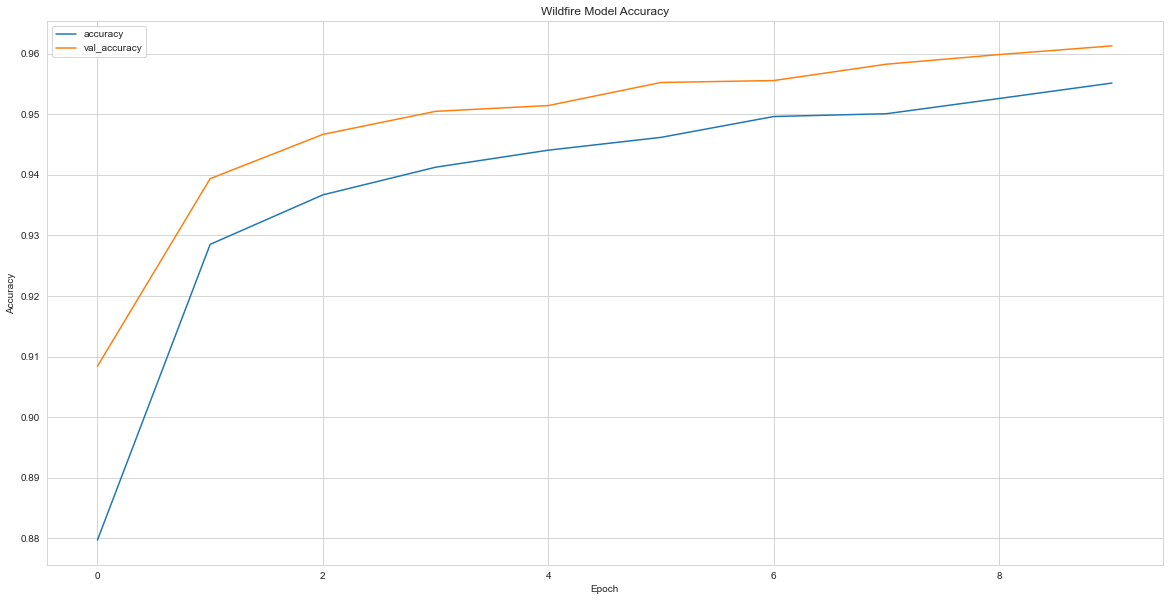

In [28]:
plot_acc(history)

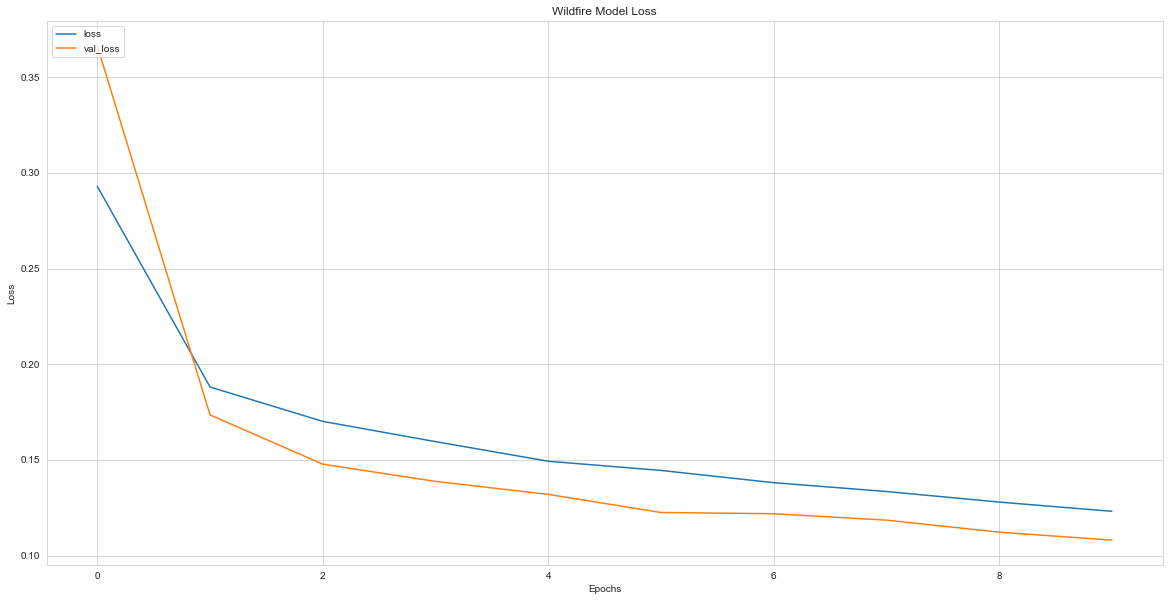

In [29]:
plot_loss(history)

In [27]:
model.save('CAM_model_10epoch.h5')
print("Model saved!")

Model saved!


# Make DataFrame for the Predictions

In [30]:
test_generator = data_generator.flow_from_directory(test_path,
                                                   batch_size = batch_size_test,
                                                   target_size = (im_size, im_size),
                                                   class_mode = 'categorical')

Found 6300 images belonging to 2 classes.


In [31]:
filenames = test_generator.filenames

In [32]:
pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1).round(3)

63/63 [==============================] - 60s 958ms/step


In [33]:
filenames_df = pd.DataFrame(filenames, columns=['File Path'])
pred_df = pd.DataFrame(pred, columns=['No Wildfire Probability', 'Wildfire Probability'])
model_predictions = pd.concat([filenames_df, pred_df], axis=1)
model_predictions

,File Path,No Wildfire Probability,Wildfire Probability
0,"nowildfire\-113.91777,50.901087.jpg",0.579,0.421
1,"nowildfire\-113.91782,50.896917.jpg",0.999,0.001
2,"nowildfire\-113.91793,51.091205.jpg",0.002,0.998
3,"nowildfire\-113.918016,50.978447.jpg",0.000,1.000
4,"nowildfire\-113.918155,51.129969.jpg",0.004,0.996
...,...,...,...
6295,"wildfire\-79.48666,47.60672.jpg",0.112,0.888
6296,"wildfire\-79.489,49.16667.jpg",0.001,0.999
6297,"wildfire\-79.49726,48.89808.jpg",0.012,0.988
6298,"wildfire\-79.50932,48.06745.jpg",0.448,0.552


In [ ]:
file_name='../data/predictions/custom_model_predictions.csv'
model_predictions.to_csv(file_name, sep=',', encoding='utf-8')

# Building Class Activation Maps

In [ ]:
# model = load_model('CAM_model_2.h5')

In [35]:
outputs = [layer.output for layer in model.layers[1:9]]

In [36]:
vis_model = Model(model.input, outputs)

In [37]:
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

In [38]:
print("Layers that will be used for visualization: ")
print(layer_names)

Layers that will be used for visualization: 
['conv2d', 'batch_normalization', 'max_pooling2d', 'conv2d_1', 'batch_normalization_1', 'max_pooling2d_1', 'conv2d_2', 'batch_normalization_2']


In [39]:
model.layers[-1]

In [40]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(64, 2)

In [41]:
cam_model  = Model(inputs=model.input, outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 32)     128 

In [42]:
plot_model(cam_model, show_shapes=True, show_layer_names=True, to_file='model_plots/cam_model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [43]:
cam_model.save('cam_model_viz')
print("Model saved!")

INFO:tensorflow:Assets written to: cam_model_viz\assets


INFO:tensorflow:Assets written to: cam_model_viz\assets


Model saved!


In [52]:
def show_cam(image_value, features, results):

  features_for_img = features[0]
  prediction = results[0]

  class_activation_weights = gap_weights[:,0]
  class_activation_features = sp.ndimage.zoom(features_for_img, (im_size/10, im_size/10, 1), order=2)  
  cam_output  = np.dot(class_activation_features,class_activation_weights)
  
  # Visualize the results
  plt.figure(figsize=(25, 25))
  plt.imshow(cam_output, cmap='jet', alpha=0.4)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.title('Class Activation Map')
  plt.figtext(.5, .05, f"No Wildfire Probability: {results[0][0] * 100}%\nWildfire Probability: {results[0][1] * 100}%", ha="center", fontsize=12, bbox={"facecolor":"green", "alpha":0.5, "pad":3})
  plt.colorbar()
  plt.show()

In [53]:
def convert_and_classify(image):
  import cv2
  img = cv2.imread(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = cv2.resize(img, (im_size, im_size)) / 255.0
  tensor_image = np.expand_dims(img, axis=0)
  features, results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

In [57]:
# img  = "G:/#Kuliah/PKL/Wildfire_Prediction_BMKG/data/test/nowildfire/-73.602,45.421799.jpg"
img  = "G:/#Kuliah/PKL/Wildfire_Prediction_BMKG/data/Screenshot (582).png"

In [58]:
gap_weights = (cam_model.layers[-1].get_weights()[0]) * -1
gap_weights.shape

(64, 2)

1/1 [==============================] - 0s 26ms/step


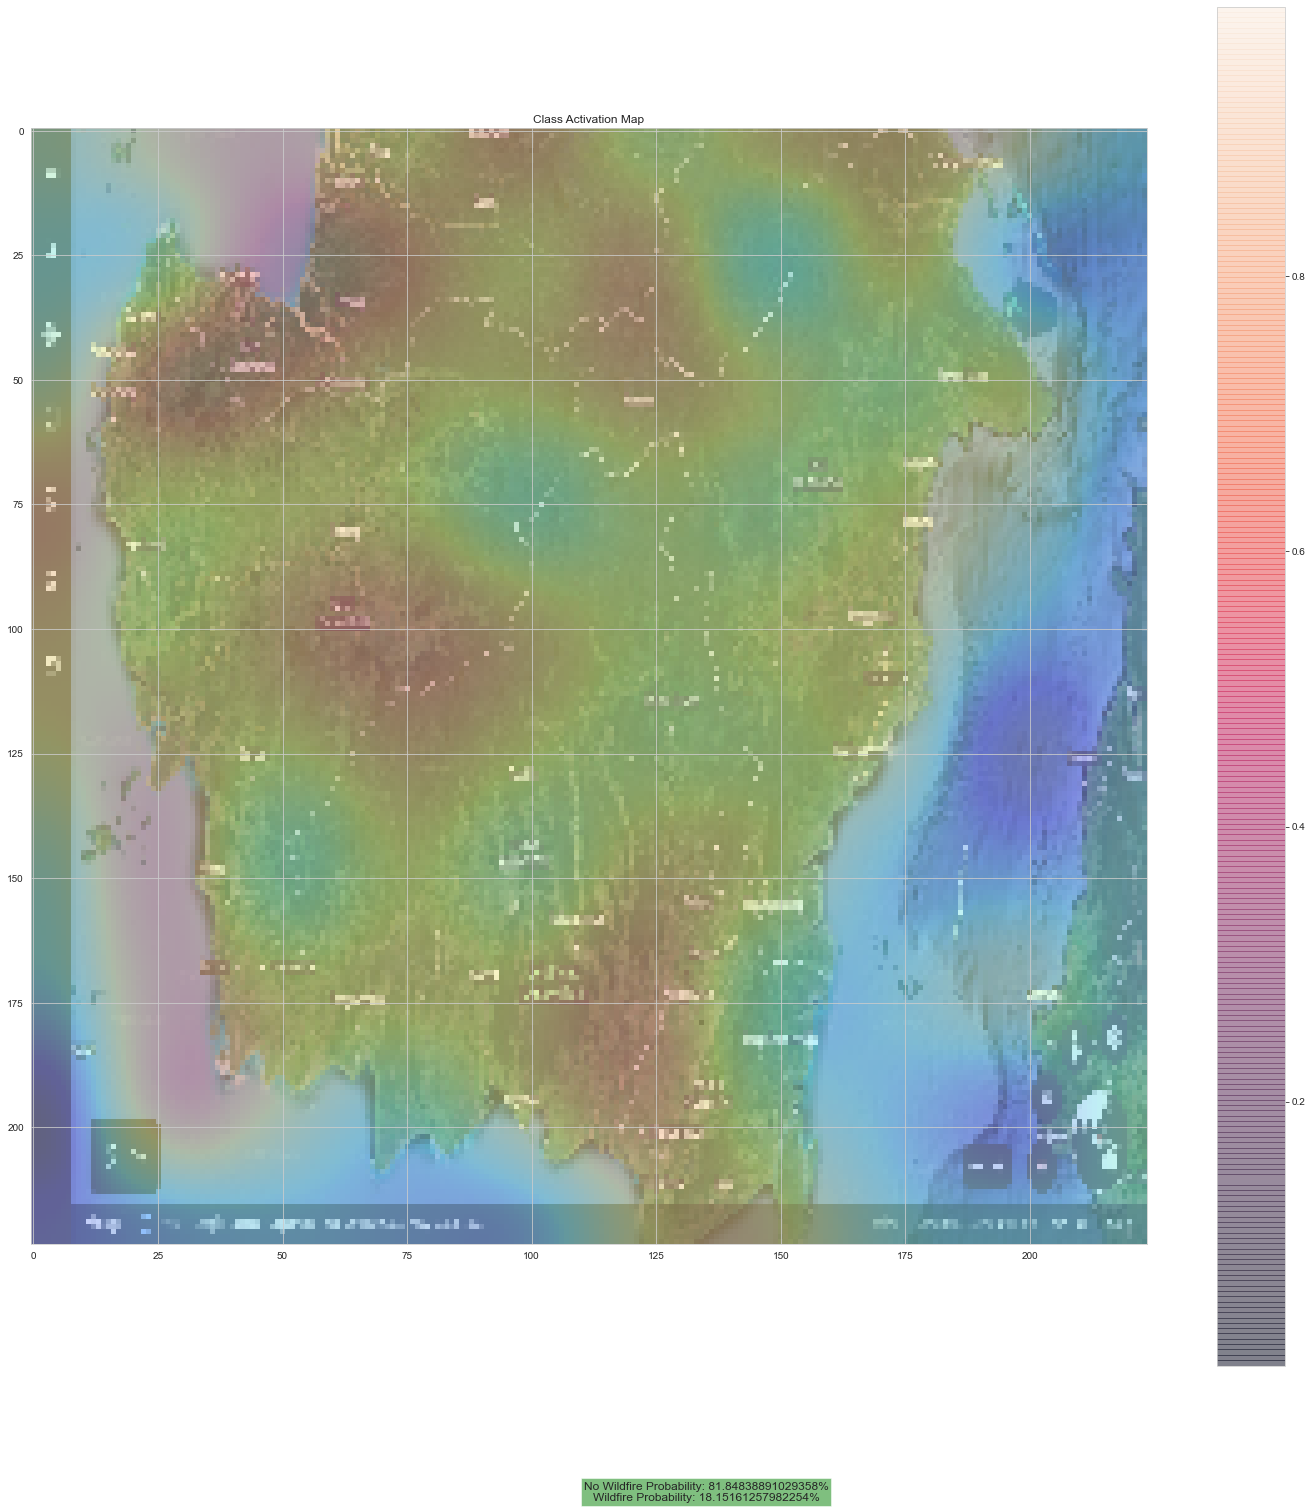

In [59]:
convert_and_classify(img)